In [1]:
### ライブラリのインポート
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

import lightgbm as lgb
import optuna

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

/Users/keitaoikoshi/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
### 定数の定義
## 入力データ
gs_file = 'gender_submission.csv'
test_file = 'test.csv'
train_file = 'train.csv'
## 出力データ
result_file = 'second_analysis.csv'
## 検証データの割合
valid_size = 0.3     # 訓練：検証＝7:3

In [3]:
### データのインポート
df_gs = pd.read_csv('original_data/' + gs_file)
df_test = pd.read_csv('original_data/' + test_file)
df_train = pd.read_csv('original_data/' + train_file)

In [4]:
### 学習データをxとyに分割
train_y = df_train['Survived']
train_x = df_train.drop(columns=['Survived'])

In [5]:
### 学習データとテストデータの結合
all_x = pd.concat([train_x, df_test])

In [6]:
### PassengerID
## 不要なので削除する
all_x = all_x.drop(columns=['PassengerId'])

In [7]:
all_x.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1309 entries, 0 to 417
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    1309 non-null   int64  
 1   Name      1309 non-null   object 
 2   Sex       1309 non-null   object 
 3   Age       1046 non-null   float64
 4   SibSp     1309 non-null   int64  
 5   Parch     1309 non-null   int64  
 6   Ticket    1309 non-null   object 
 7   Fare      1308 non-null   float64
 8   Cabin     295 non-null    object 
 9   Embarked  1307 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 112.5+ KB


In [8]:
### Survived
pass

In [9]:
### Pclass
pass

In [11]:
### Name
### Titleを抽出し、6つにマージする

## 0. Titleの一覧を取得する
# データの確認のために行う
titles = set()
for name in all_x['Name']:
    titles.add(name.split(',')[1].split('.')[0].strip())

## 1. NameとTitleの対応表を作る
Title_Dictionary = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess":"Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Royalty"
}

## 2. Name→Titleの変換関数を定義する
def get_titles():
    # 名前からTitleを取得する
    all_x['Title'] = all_x['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())
    # 辞書を使って変換する
    all_x['Title'] = all_x.Title.map(Title_Dictionary)
    return all_x

## 3. 実際に変換する
all_x = get_titles()

## 4. Name列を削除する
all_x = all_x.drop(['Name'], axis=1)


In [12]:
### Sex
pass

In [ ]:
### Age

## 1. 3カラムをキーにグループ化し、各グループの年齢の中央値を求める
grouped_train = all_x.iloc[:891].groupby(['Sex','Pclass','Title'])
grouped_median_train = grouped_train.Age.median()
grouped_median_train = grouped_median_train.reset_index()[['Sex', 'Pclass', 'Title', 'Age']]
# 最大でも高々36通りなので、全部可視化してみる
# print(grouped_median_train)

## 2. 各行の3カラムの組み合わせに対応する年齢の中央値を返す関数を定義する
def fill_age(row):
    condition = (
        (grouped_median_train['Sex'] == row['Sex']) & 
        (grouped_median_train['Title'] == row['Title']) & 
        (grouped_median_train['Pclass'] == row['Pclass'])
    ) 
    return grouped_median_train[condition]['Age'].values[0]

## 3. 2を使って欠損値補完する
def process_age():
    global all_x
    # a function that fills the missing values of the Age variable
    all_x['Age'] = all_x.apply(lambda row: fill_age(row) if np.isnan(row['Age']) else row['Age'], axis=1)
    return all_x

## 4. 処理を実行する
all_x = process_age()

In [18]:
### SibSp
### Parch
## まとめてFamily_sizeカラムを作成する
def process_family():
    global all_x
    all_x['FamilySize'] = all_x['SibSp'] + all_x['Parch'] + 1
    return all_x
all_x = process_family()

TypeError: 'function' object is not subscriptable

In [129]:
### Ticket
## 1. 同じチケットの出現回数をカウントする
all_x['SameTicket_Count'] = all_x.groupby('Ticket')['Ticket'].transform('count')

## 2. Ticket列を削除する
all_x = all_x.drop(columns=['Ticket'])

In [ ]:
### Fare
## 全体の平均値補間でする
def process_fares():
    global all_x
    all_x.Fare.fillna(all_x.iloc[:891].Fare.mean(), inplace=True)
    return all_x
all_x = process_fares()

In [ ]:
### Cabin
## 1文字目を採用する
def process_cabin():
    global all_x
    # 1. 欠損値を'U'で補間する
    all_x['Cabin'].fillna('U', inplace=True)
    # 2. カラムの内容を、1文字目に変換する
    all_x['Cabin'] = all_x['Cabin'].map(lambda c: c[0])

    return all_x

all_x = process_cabin

In [132]:
### Embarked
## 欠損値フラグ
all_x['Embarked'] = all_x['Embarked'].apply(lambda x: 'N' if pd.isna(x) or x == '' else x)

In [133]:
### カテゴリ変数化
## 対象：Sex, Cabin_flag, Embarked
## 方法：get_dummies関数

all_x = pd.get_dummies(all_x, columns=['Sex', 'Cabin_flag', 'Embarked', 'Title', 'Pclass'])

In [134]:
### 学習データとテストデータに再分割（参考：Kaggleで勝つ P138）
processed_train_x = all_x.iloc[:train_x.shape[0], :].reset_index(drop=True)
processed_test_x = all_x.iloc[train_x.shape[0]:, :].reset_index(drop=True)

ここから分析

In [135]:
### 混交行列の可視化関数
def heat_map(cm):
    cm_matrix = pd.DataFrame(data=cm,columns=['Actual Positive:1','Actual Negative:0'],
                            index=['Predict Positive:1','Predict Negative:0'])
    
    # ヒートマップで描画
    plt.figure(figsize=(3, 3))
    heatmap = sns.heatmap(cm_matrix, annot=True, fmt='d',cmap='coolwarm')
    # heatmap.set_title('混同行列',fontsize=20)
    heatmap.set_xticks([0.5,1.5])
    heatmap.set_xlabel('予測',fontsize=15)
    heatmap.set_xticklabels(['Negative:0','Positive:1'],fontsize=12)
    heatmap.set_ylabel('真値',fontsize=15)
    heatmap.set_yticks([0.5,1.5])
    heatmap.set_yticklabels(['Negative:0','Positive:1'],fontsize=12)

In [136]:
### データの分割
x_train, x_valid, y_train, y_valid = train_test_split(
    processed_train_x, train_y,          # 入力とラベル
    test_size=valid_size,             # 検証データの割合（30%）
    random_state=42,           # 乱数シード（再現性のため）
    shuffle=True               # シャッフルして分割（デフォルトTrue）
)

In [137]:
### optunaの準備
## 評価指標はaccuracy
def objective_gbdt(trial):

    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_test = lgb.Dataset(x_valid, y_valid, reference=lgb_train)
    
    param = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': {'binary_error'},#binary_error

        'lambda_l1'         : trial.suggest_float('lambda_l1', 1e-8, 1.0, log=True),
        'lambda_l2'         : trial.suggest_float('lambda_l2', 1e-8, 1.0, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 1.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 50),

        'force_col_wise':True,
        'random_state': 0,
        }
    
    
    model = lgb.train(
        params=param,
        train_set=lgb_train,
        valid_sets=[lgb_test],
        valid_names=['Test'],
        num_boost_round=100,
        callbacks=[
            lgb.early_stopping(stopping_rounds=50, verbose=False),  # ログなしで early stopping
            lgb.log_evaluation(0)  # ログ完全オフ
        ]
    )

    
    # 推論
    pred = model.predict(x_valid, num_iteration=model.best_iteration)
    y_pred = np.where(pred < 0.5, 0, 1) # 0.5より小さい場合0 ,そうでない場合1を返す

    # 評価
    #＝＝＝＝＝＝＝＝＝＝＝利用したい評価指標に変更＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝
    score = accuracy_score(y_valid, y_pred)

    return score

In [ ]:
### optunaの実行
study = optuna.create_study(direction='maximize',sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective_gbdt, n_trials=200)

print("=======ベストパラメータ========")
print(study.best_params)

In [139]:
### 調整したパラメータで学習
lgb_train = lgb.Dataset(x_train, y_train)
lgb_test = lgb.Dataset(x_valid, y_valid, reference=lgb_train)

param = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'binary_error'},#binary_error
    'force_col_wise':True,
    'random_state': 0,
    }
param.update(study.best_params)

model = lgb.train(
                # **study.best_params,              # ハイパーパラメータをセット
                params=param,
                

                train_set=lgb_train,              # 訓練データを訓練用にセット
                valid_sets=[lgb_train, lgb_test], # 訓練データとテストデータをセット
                valid_names=['Train', 'Validation'],    # データセットの名前をそれぞれ設定
                num_boost_round=100,              # 計算回数
                callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=1),
                           lgb.log_evaluation(10),],         # アーリーストッピング設定

                # evals_result=lgb_results,
                # verbose_eval=-1,                  # ログを最後の1つだけ表示
                )


# prediction
pred = model.predict(x_valid, num_iteration=model.best_iteration)
y_pred = np.where(pred < 0.5, 0, 1) # 0.5より小さい場合0 ,そうでない場合1を返す

[LightGBM] [Info] Number of positive: 231, number of negative: 392
[LightGBM] [Info] Total Bins 216
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.370787 -> initscore=-0.528844
[LightGBM] [Info] Start training from score -0.528844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

/Users/keitaoikoshi/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20104 (\N{CJK UNIFIED IDEOGRAPH-4E88}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/keitaoikoshi/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 28204 (\N{CJK UNIFIED IDEOGRAPH-6E2C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/keitaoikoshi/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/keitaoikoshi/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20516 (\N{CJK UNIFIED IDEOGRAPH-5024}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


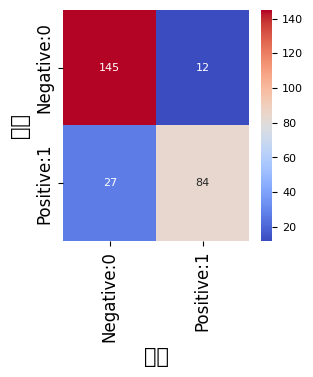

In [140]:
### 混合行列の可視化
# cm = confusion_matrix(y_valid,y_pred)
cm = confusion_matrix(y_pred=y_pred,y_true=y_valid)
heat_map(cm)
plt.xticks(rotation=90)
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

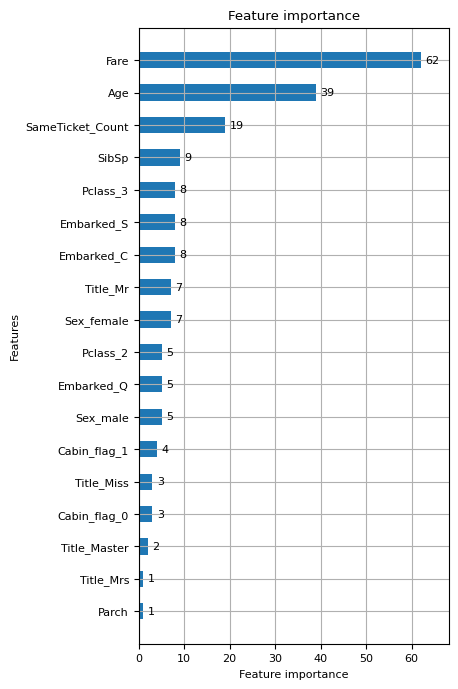

In [141]:
### 特徴量重要度の可視化
plt.rcParams["font.size"] = 8
lgb.plot_importance(model, height = 0.5, figsize = (4,8),)

In [142]:
### 予測の実行
pred_test = model.predict(processed_test_x, num_iteration=model.best_iteration)
y_pred_test = np.where(pred_test < 0.5, 0, 1)

In [143]:
y_test_df = pd.DataFrame(y_pred_test, columns=['Survived'])

In [144]:
result_df = pd.concat([df_test['PassengerId'], y_test_df], axis=1)

In [145]:
result_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [147]:
result_df.to_csv('processed_data/' + result_file, index=False)